In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import hashlib
import os
import os
import shutil
from datetime import datetime, timedelta


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', None)

root_dir = os.path.dirname(os.getcwd()) + "/"

In [2]:
# Load the .npy files into a list
npy_files = sorted(glob(root_dir + 'data/npy_files/*.npy'))

# Load the first .npy file to get the unique latitudes and longitudes of this data set
example_grid = np.load(npy_files[0])

In [3]:
for i in enumerate(npy_files):
    array = np.load(i[1])
    
    array[array < 20] = 0
    array[array > 80] = 80

    np.save(i[1], array)

In [4]:
# Assume npy_files and unique_latitudes, unique_longitudes are already defined
sequence_length = 15 # Number of .npy files to look back on
prediction_horizon = 15 # Number of .npy files to predict

In [5]:
def split_single_grid(file, square_size, height, width):
    grid = np.load(file).reshape(height, width, 1)
    squares = [
        grid[i:i+square_size, j:j+square_size]
        for i in range(0, height, square_size)
        for j in range(0, width, square_size)
    ]
    return np.array(squares)

# Function to split all grids sequentially (no parallelization)
def split_all_grids_sequential(npy_files, square_size=250, height=3500, width=7000):
    num_squares_per_grid = (height // square_size) * (width // square_size)
    num_files = len(npy_files)

    # Preallocate space for all the grids that will be split into squares
    all_squares = np.empty((num_files, num_squares_per_grid, square_size, square_size, 1), dtype=np.float32)

    # Sequentially process each file and store the result
    for idx, file in enumerate(npy_files):
        squares = split_single_grid(file, square_size, height, width)
        all_squares[idx] = squares

    return all_squares

# Assume npy_files, sequence_length, and prediction_horizon are already defined
square_size = 175
height, width = 3500, 7000  # Original image size
num_squares = 800

# Pre-split all grids into squares sequentially
all_squares = split_all_grids_sequential(npy_files, square_size=square_size, height=height, width=width)

# Now, treat each square as an independent sample
num_files = len(npy_files)
num_samples = (num_files - sequence_length - prediction_horizon + 1) * num_squares

# Pre-allocate arrays for input (X) and output (y) sequences
X = np.empty((num_samples, sequence_length, square_size, square_size, 1), dtype=np.float32)
y = np.empty((num_samples, prediction_horizon, square_size, square_size, 1), dtype=np.float32)

# Populate X and y arrays using pre-split squares
sample_idx = 0
for i in range(num_files - sequence_length - prediction_horizon + 1):
    for j in range(num_squares):
        # For each sample, take the sequence for that square over time
        x_sample = all_squares[i:i+sequence_length, j]
        X[sample_idx] = x_sample

        y_sample = all_squares[i+sequence_length:i+sequence_length+prediction_horizon, j]
        y[sample_idx] = y_sample

        sample_idx += 1

In [6]:
def remove_duplicates(X, y):
    """
    Removes duplicates from X and y where every pixel in the image sequences is the same.
    Only unique (X, y) pairs are retained.
    
    Args:
    - X: numpy array of shape (num_samples, sequence_length, image_width, image_height, 1)
    - y: numpy array of shape (num_samples, prediction_horizon, image_width, image_height, 1)
    
    Returns:
    - X_unique: numpy array of unique input sequences
    - y_unique: numpy array of corresponding unique output sequences
    """
    unique_indices = []
    num_samples = X.shape[0]
    
    # Track whether we've already seen a duplicate
    seen = np.zeros(num_samples, dtype=bool)
    
    for i in range(num_samples):
        if seen[i]:
            continue  # Skip if this sample was already identified as a duplicate
        
        # Mark the current sample as part of the unique set
        unique_indices.append(i)
        
        # Check for duplicates in the rest of the dataset
        for j in range(i + 1, num_samples):
            if seen[j]:
                continue  # Skip already marked duplicates
            
            # Check if both X and y sequences are identical
            if np.array_equal(X[i], X[j]) and np.array_equal(y[i], y[j]):
                seen[j] = True  # Mark this as a duplicate
    
    # Select only the unique indices for X and y
    X_unique = X[unique_indices]
    y_unique = y[unique_indices]
    
    return X_unique, y_unique

X_unique, y_unique = remove_duplicates(X, y)

X_unique = X_unique / 80
y_unique = y_unique / 80

In [7]:
# Split data into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# First split: train and temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_unique, y_unique, test_size=(1 - train_ratio)
)

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(test_ratio / (test_ratio + val_ratio))
)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(323, 15, 175, 175, 1)
(69, 15, 175, 175, 1)
(70, 15, 175, 175, 1)
(323, 15, 175, 175, 1)
(69, 15, 175, 175, 1)
(70, 15, 175, 175, 1)


Frame x - 2 is the same as the previous frame.
Frame x - 3 is the same as the previous frame.
Frame x - 4 is the same as the previous frame.
Frame x - 5 is the same as the previous frame.
Frame x - 6 is the same as the previous frame.
Frame x - 7 is the same as the previous frame.
Frame x - 8 is the same as the previous frame.
Frame x - 9 is the same as the previous frame.
Frame x - 10 is the same as the previous frame.
Frame x - 11 is the same as the previous frame.
Frame x - 12 is the same as the previous frame.
Frame x - 14 is the same as the previous frame.
Frame x - 15 is the same as the previous frame.
Displaying frames for example 306.
Frame y - 2 is the same as the previous frame.
Frame y - 3 is the same as the previous frame.
Frame y - 4 is the same as the previous frame.
Frame y - 5 is the same as the previous frame.
Frame y - 6 is the same as the previous frame.
Frame y - 7 is the same as the previous frame.
Frame y - 8 is the same as the previous frame.
Frame y - 9 is the s

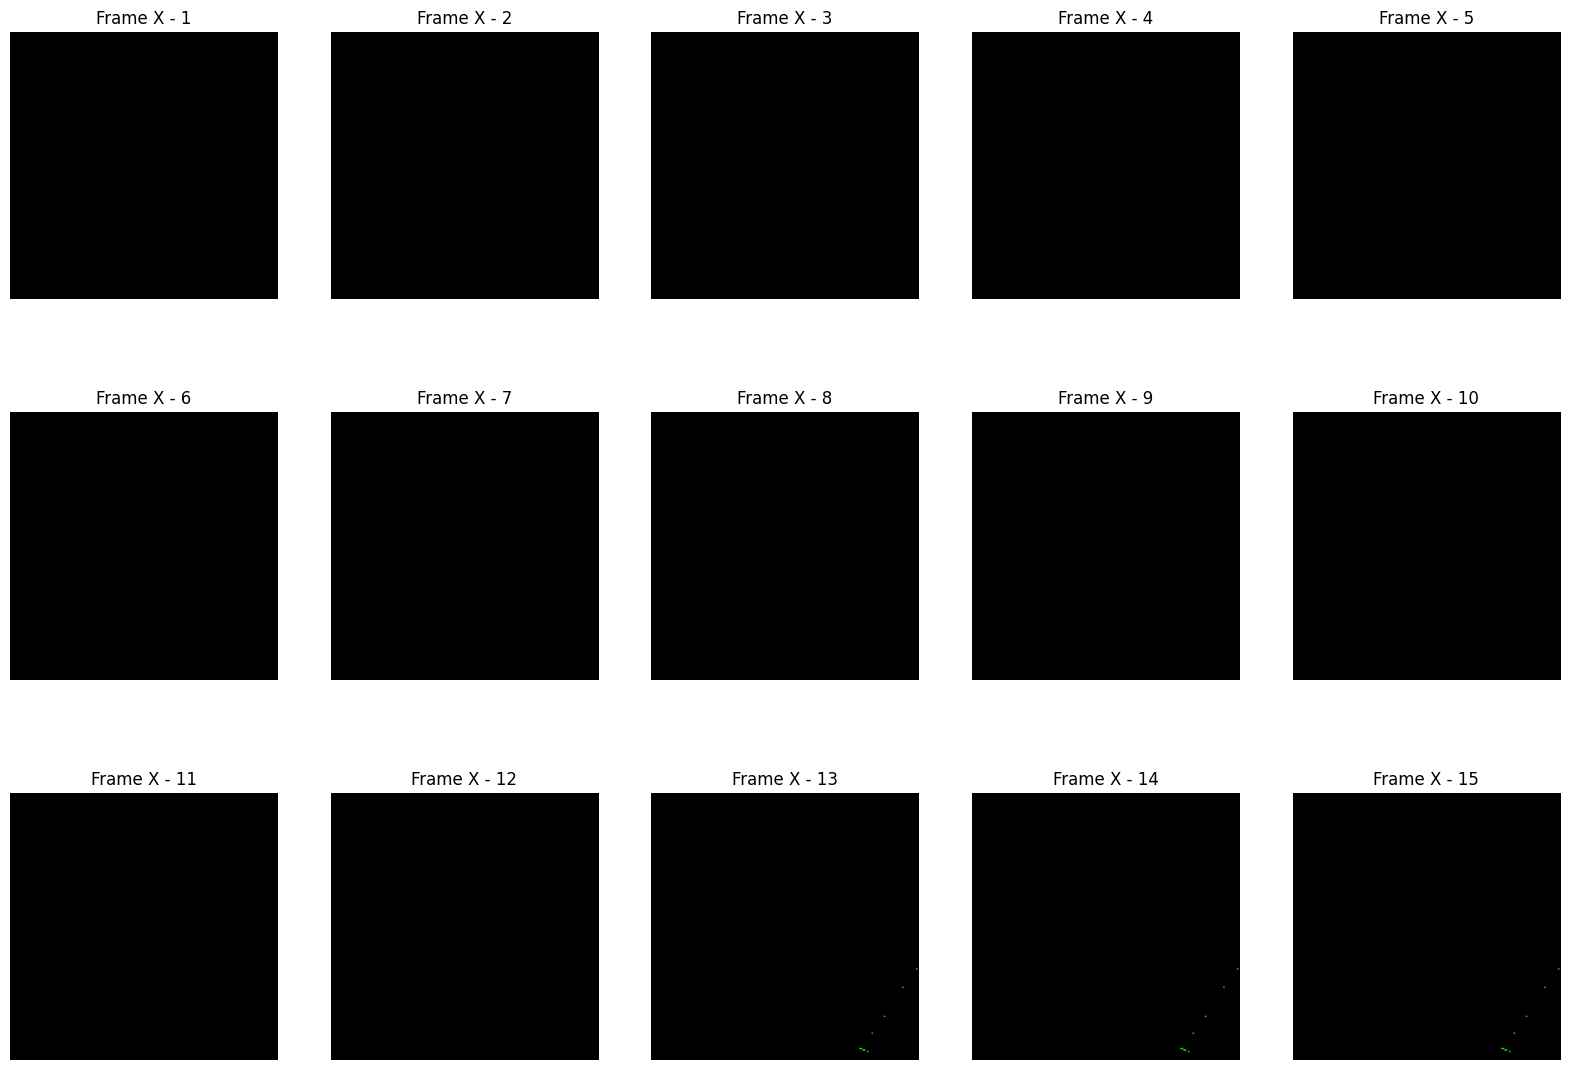

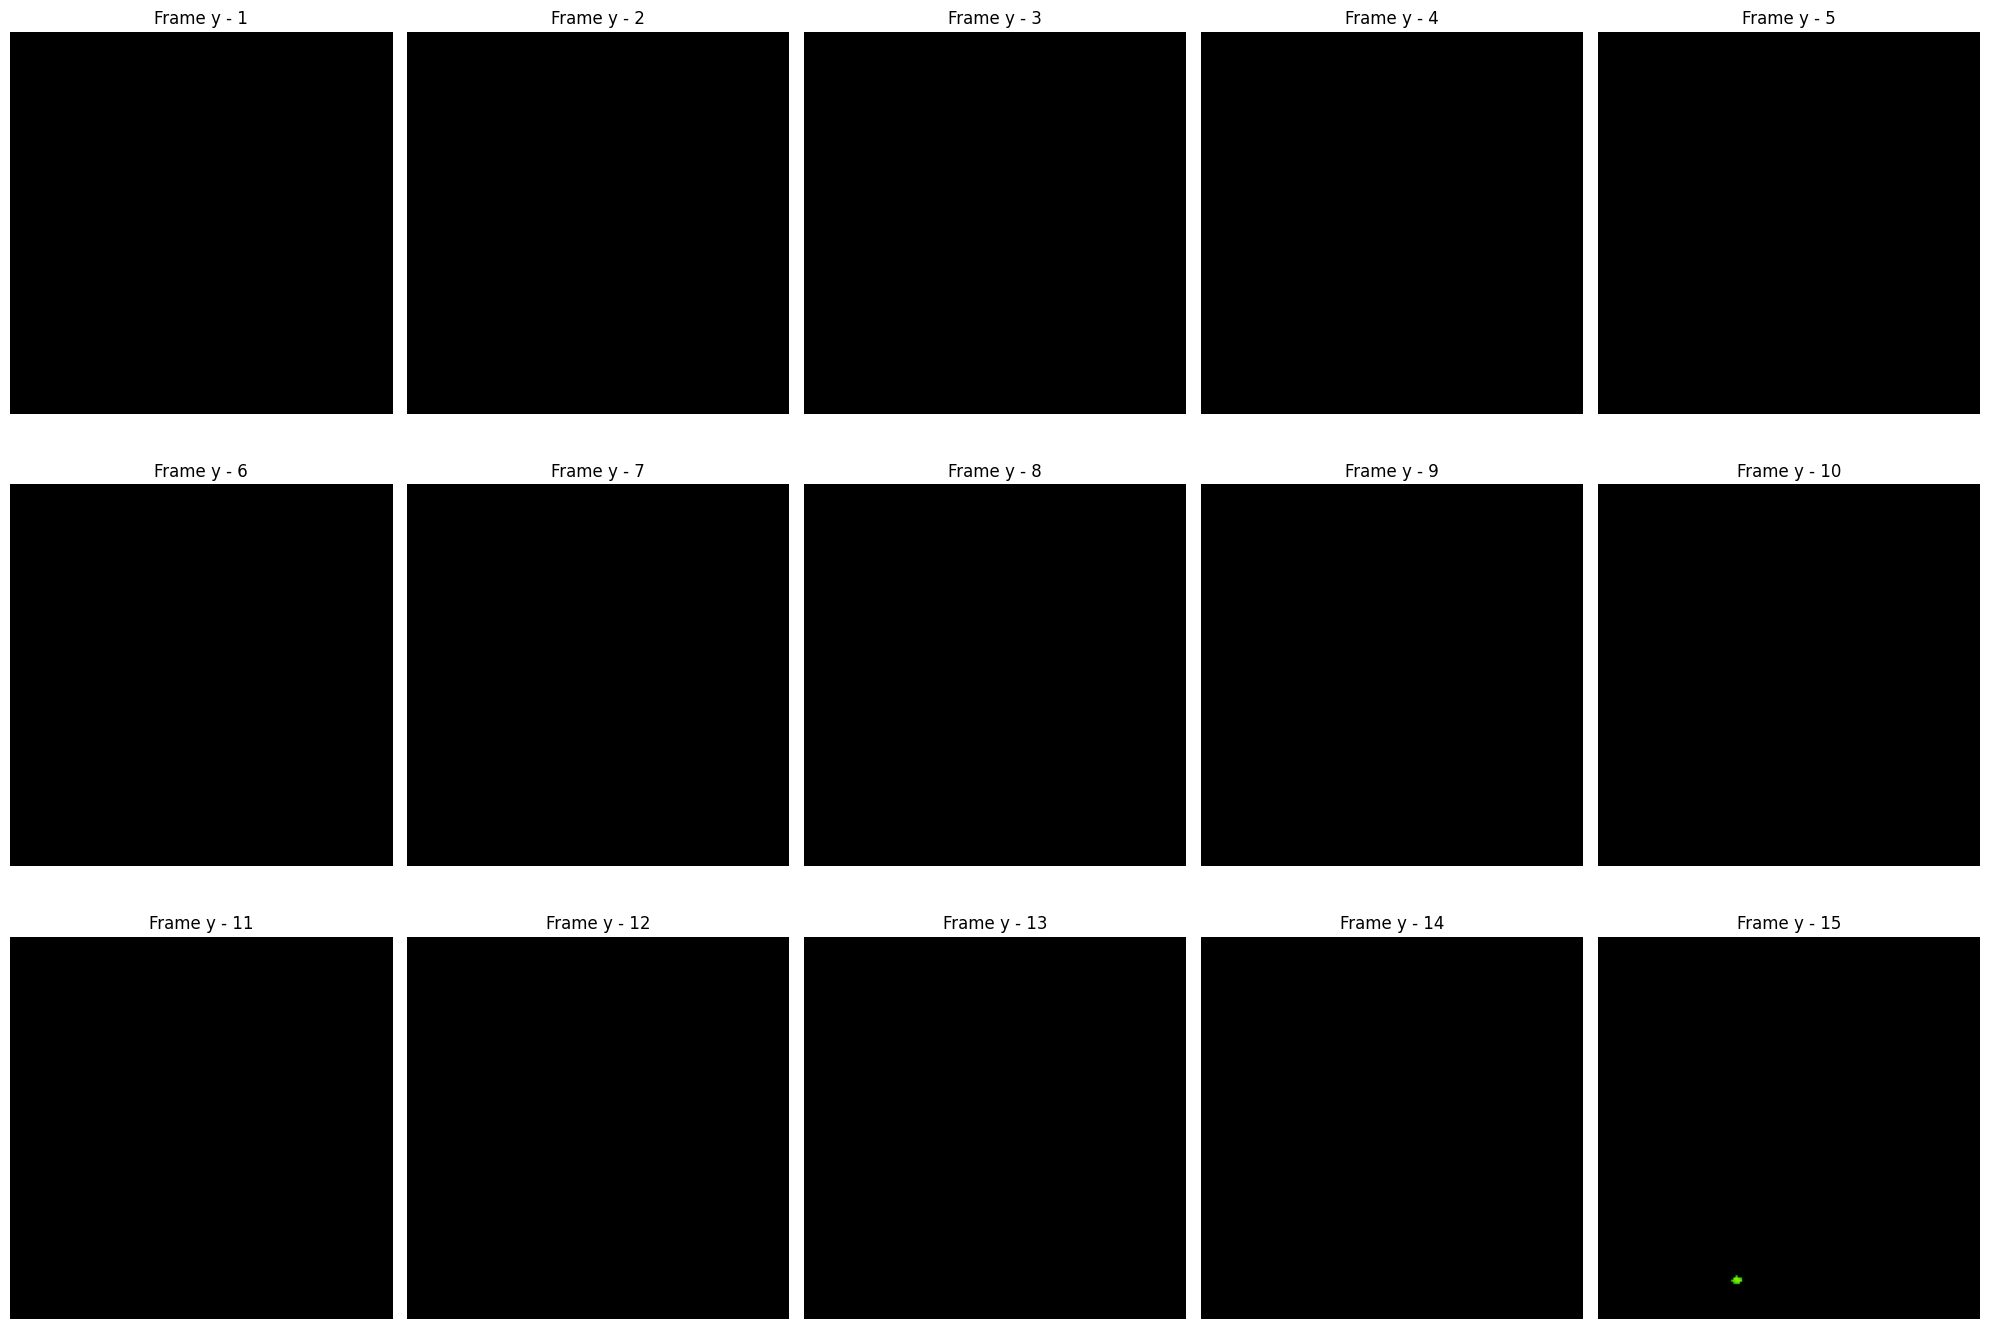

In [8]:
# Define the colors for the radar map, introducing white for values between 0 and 15
colors = [
    (0, 0, 0),         # White for values 0-15 (no precipitation or very light)
    (0, 0.7, 0),       # Green (light precipitation)
    (1, 1, 0),         # Yellow (moderate precipitation)
    (1, 0.65, 0),      # Orange (heavy precipitation)
    (1, 0, 0),         # Red (very heavy precipitation)
    (0.6, 0, 0.6)      # Purple (extreme precipitation)
]

breakpoints = [0.0, .15/1.0, .40/1.0, .60/1.0, .70/1.0, 1.0]

# Create the custom colormap
radar_cmap = LinearSegmentedColormap.from_list('radar', colors, N=80)

# Normalize the data range from 0 to 80
norm = Normalize(vmin=0, vmax=1)

# Construct a figure to visualize the images
x_fig, x_axes = plt.subplots(3, 5, figsize=(20, 14))
y_fig, y_axes = plt.subplots(3, 5, figsize=(20, 14))

# Randomly choose a data example to visualize
data_choice = np.random.choice(range(len(X_train)), size=1)[0]
lastdata = None  # Initialize lastdata to None before looping

# Plot each of the sequential images for one random data example
for idx, ax in enumerate(x_axes.flat):
    x_thisdata = X_train[data_choice][idx]

    # Compare the current data to the last one if lastdata is not None
    if lastdata is not None and np.array_equal(x_thisdata, lastdata):
        print(f"Frame x - {idx + 1} is the same as the previous frame.")

    # Display the image with the radar colormap and normalization
    im = ax.imshow(np.squeeze(x_thisdata), cmap=radar_cmap, norm=norm)
    
    # Add title and remove axis
    ax.set_title(f"Frame X - {idx + 1}")
    ax.axis("off")

    # Update lastdata
    lastdata = x_thisdata

# Print information and display the figure
print(f"Displaying frames for example {data_choice}.")

for idx, ax in enumerate(y_axes.flat):
    y_thisdata = y_train[data_choice][idx]

    # Compare the current data to the last one if lastdata is not None
    if lastdata is not None and np.array_equal(y_thisdata, lastdata):
        print(f"Frame y - {idx + 1} is the same as the previous frame.")

    # Display the image with the radar colormap and normalization
    im = ax.imshow(np.squeeze(y_thisdata), cmap=radar_cmap, norm=norm)
    
    # Add title and remove axis
    ax.set_title(f"Frame y - {idx + 1}")
    ax.axis("off")

    # Update lastdata
    lastdata = y_thisdata

plt.tight_layout()
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D, BatchNormalization, Input, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from tensorflow.keras.optimizers import AdamW
import subprocess

# channels = 1  # Reflectivity is your feature, so 1 channel

# # Define the model using an Input layer for the input shape
# model = Sequential()

# # Add Input Layer
# model.add(Input(shape=(sequence_length, square_size, square_size, channels))) 

# # First ConvLSTM2D layer with return_sequences=True
# model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# # Second ConvLSTM2D layer with return_sequences=True to return all frames
# model.add(ConvLSTM2D(filters=126, kernel_size=(3, 3), padding='same', return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# # Third ConvLSTM2D layer
# model.add(ConvLSTM2D(filters=256, kernel_size=(3, 3), padding='same', return_sequences=True))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# # Replace Conv3D with Conv2D to predict the next frame(s)
# model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same'))

# optimizer = AdamW(learning_rate=0.0001)

# # Compile the model
# model.compile(loss='mse', optimizer=optimizer)

# # Print model summary
# model.summary()

2024-10-18 21:31:19.305561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 21:31:19.320434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 21:31:19.324888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 21:31:19.337775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 21:31:20.289155: W tensorflow/compiler/tf2

In [10]:
model_name = "model6_6.keras"
model = load_model(root_dir + f"model/{model_name}")
# # Create an Adam optimizer with a custom learning rate
optimizer = AdamW(learning_rate=0.0001)  # Set the learning rate here

# # Compile the model with the optimizer
model.compile(loss='mae', optimizer=optimizer)

I0000 00:00:1729287081.072235    4989 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729287081.079370    4989 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729287081.123953    4989 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729287081.126196    4989 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
def get_model_memory_usage(batch_size, model):
    features_mem = 0  # Initialize memory for features
    float_bytes = 4.0  # Float32 uses 4 bytes
    
    for layer in model.layers:
        # Use layer.output.shape to get the output shape instead of output_shape
        out_shape = layer.output.shape
        
        # Remove the batch size dimension (out_shape[0]) and None (which represents the batch dimension)
        out_shape = [dim for dim in out_shape if dim is not None]
        
        # Multiply all output shape dimensions to calculate the number of elements per layer
        single_layer_mem = 1
        for s in out_shape:
            single_layer_mem *= s
            
        # Convert to memory (in bytes and MB)
        single_layer_mem_float = single_layer_mem * float_bytes  # Multiply by 4 bytes (float32)
        single_layer_mem_MB = single_layer_mem_float / (1024 ** 2)  # Convert to MB
        
        print(f"Memory for layer {layer.name} with output shape {out_shape} is: {single_layer_mem_MB:.2f} MB")
        
        features_mem += single_layer_mem_MB  # Accumulate total feature memory
    
    # Calculate Parameter memory
    trainable_wts = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_wts = np.sum([K.count_params(p) for p in model.non_trainable_weights])
    parameter_mem_MB = ((trainable_wts + non_trainable_wts) * float_bytes) / (1024 ** 2)
    
    print("_________________________________________")
    print(f"Memory for features in MB is: {features_mem * batch_size:.2f} MB")
    print(f"Memory for parameters in MB is: {parameter_mem_MB:.2f} MB")

    total_memory_MB = (batch_size * features_mem) + parameter_mem_MB
    total_memory_GB = total_memory_MB / 1024  # Convert to GB
    
    return total_memory_GB

#####################################################################

mem_for_my_model = get_model_memory_usage(1, model)

print("_________________________________________")
print("Minimum memory required to work with this model is: %.2f" %mem_for_my_model, "GB")

Memory for layer conv_lstm2d with output shape [15, 175, 175, 64] is: 112.15 MB
Memory for layer batch_normalization with output shape [15, 175, 175, 64] is: 112.15 MB
Memory for layer activation with output shape [15, 175, 175, 64] is: 112.15 MB
Memory for layer conv_lstm2d_1 with output shape [15, 175, 175, 126] is: 220.80 MB
Memory for layer batch_normalization_1 with output shape [15, 175, 175, 126] is: 220.80 MB
Memory for layer activation_1 with output shape [15, 175, 175, 126] is: 220.80 MB
Memory for layer conv_lstm2d_2 with output shape [15, 175, 175, 256] is: 448.61 MB
Memory for layer batch_normalization_2 with output shape [15, 175, 175, 256] is: 448.61 MB
Memory for layer activation_2 with output shape [15, 175, 175, 256] is: 448.61 MB
Memory for layer conv3d with output shape [15, 175, 175, 1] is: 1.75 MB
_________________________________________
Memory for features in MB is: 2346.43 MB
Memory for parameters in MB is: 17.33 MB
_________________________________________
Min

In [12]:
cp = ModelCheckpoint(root_dir + f"model/{model_name}", save_best_only=True)
# early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=5)

# Train the model
history = model.fit(X_train, y_train, 
          batch_size=2, 
          epochs=10, 
          callbacks=[cp],
          validation_data=(X_val, y_val))

Epoch 1/10


I0000 00:00:1729287089.053997    5399 service.cc:146] XLA service 0x7f04ec010d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729287089.054043    5399 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1729287089.054050    5399 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-18 21:31:29.350212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-18 21:31:30.024310: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-18 21:31:31.297522: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be perf

161/162 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 0.0358

2024-10-18 21:33:09.058048: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-18 21:33:09.615310: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


162/162 ━━━━━━━━━━━━━━━━━━━━ 118s 648ms/step - loss: 0.0357 - val_loss: 0.0321
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 588ms/step - loss: 0.0178 - val_loss: 0.0232
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 588ms/step - loss: 0.0272 - val_loss: 0.0116
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 588ms/step - loss: 0.0153 - val_loss: 0.0116
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 588ms/step - loss: 0.0210 - val_loss: 0.0097
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 586ms/step - loss: 0.0180 - val_loss: 0.0201
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 587ms/step - loss: 0.0219 - val_loss: 0.0163
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 586ms/step - loss: 0.0159 - val_loss: 0.0327
Epoch 9/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 587ms/step - loss: 0.0176 - val_loss: 0.0104
Epoch 10/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 95s 587ms/step - loss: 0.0215 - val_loss: 0.0268


In [13]:
# Path to the model saved by ModelCheckpoint
model_path = root_dir + f"model/{model_name}"

val_loss = history.history['val_loss']  # List of validation losses for each epoch
average_val_loss = sum(val_loss) / len(val_loss)  # Compute the average val_loss
num_epochs = len(val_loss)  # Number of epochs is the length of the val_loss list

# Create the commit message including average val_loss and number of epochs
commit_message = f"Trained model: {model_name} with avg_val_loss: {average_val_loss:.4f} epochs: {num_epochs}"

commands = [
    "git config --global user.email 'tw@trevorwiebe.com'",
    "git config --global user.name 'Trevor Wiebe'",
    f"git add {model_path}",  # Assuming `model_path` is where your model is saved
    f'git commit -m "{commit_message}"',
    "git push"
]

# Execute Git commands
for command in commands:
    try:
        subprocess.run(command, check=True, shell=True)
        print(f"Successfully executed: {command}")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while executing: {command}\nError: {e}")

Successfully executed: git config --global user.email 'tw@trevorwiebe.com'
Successfully executed: git config --global user.name 'Trevor Wiebe'
Successfully executed: git add /root/radar-data/radar_data/model/model6_6.keras
[main 7533c1a] Trained model: model6_6.keras with avg_val_loss: 0.0194 epochs: 10
 1 file changed, 0 insertions(+), 0 deletions(-)
Successfully executed: git commit -m "Trained model: model6_6.keras with avg_val_loss: 0.0194 epochs: 10"
Successfully executed: git push


remote: warning: See https://gh.io/lfs for more information.        
remote: warning: File radar_data/model/model6_6.keras is 52.04 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB        
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.        
To github.com:trevorwiebe/radar-data.git
   bbfd40a..7533c1a  main -> main


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


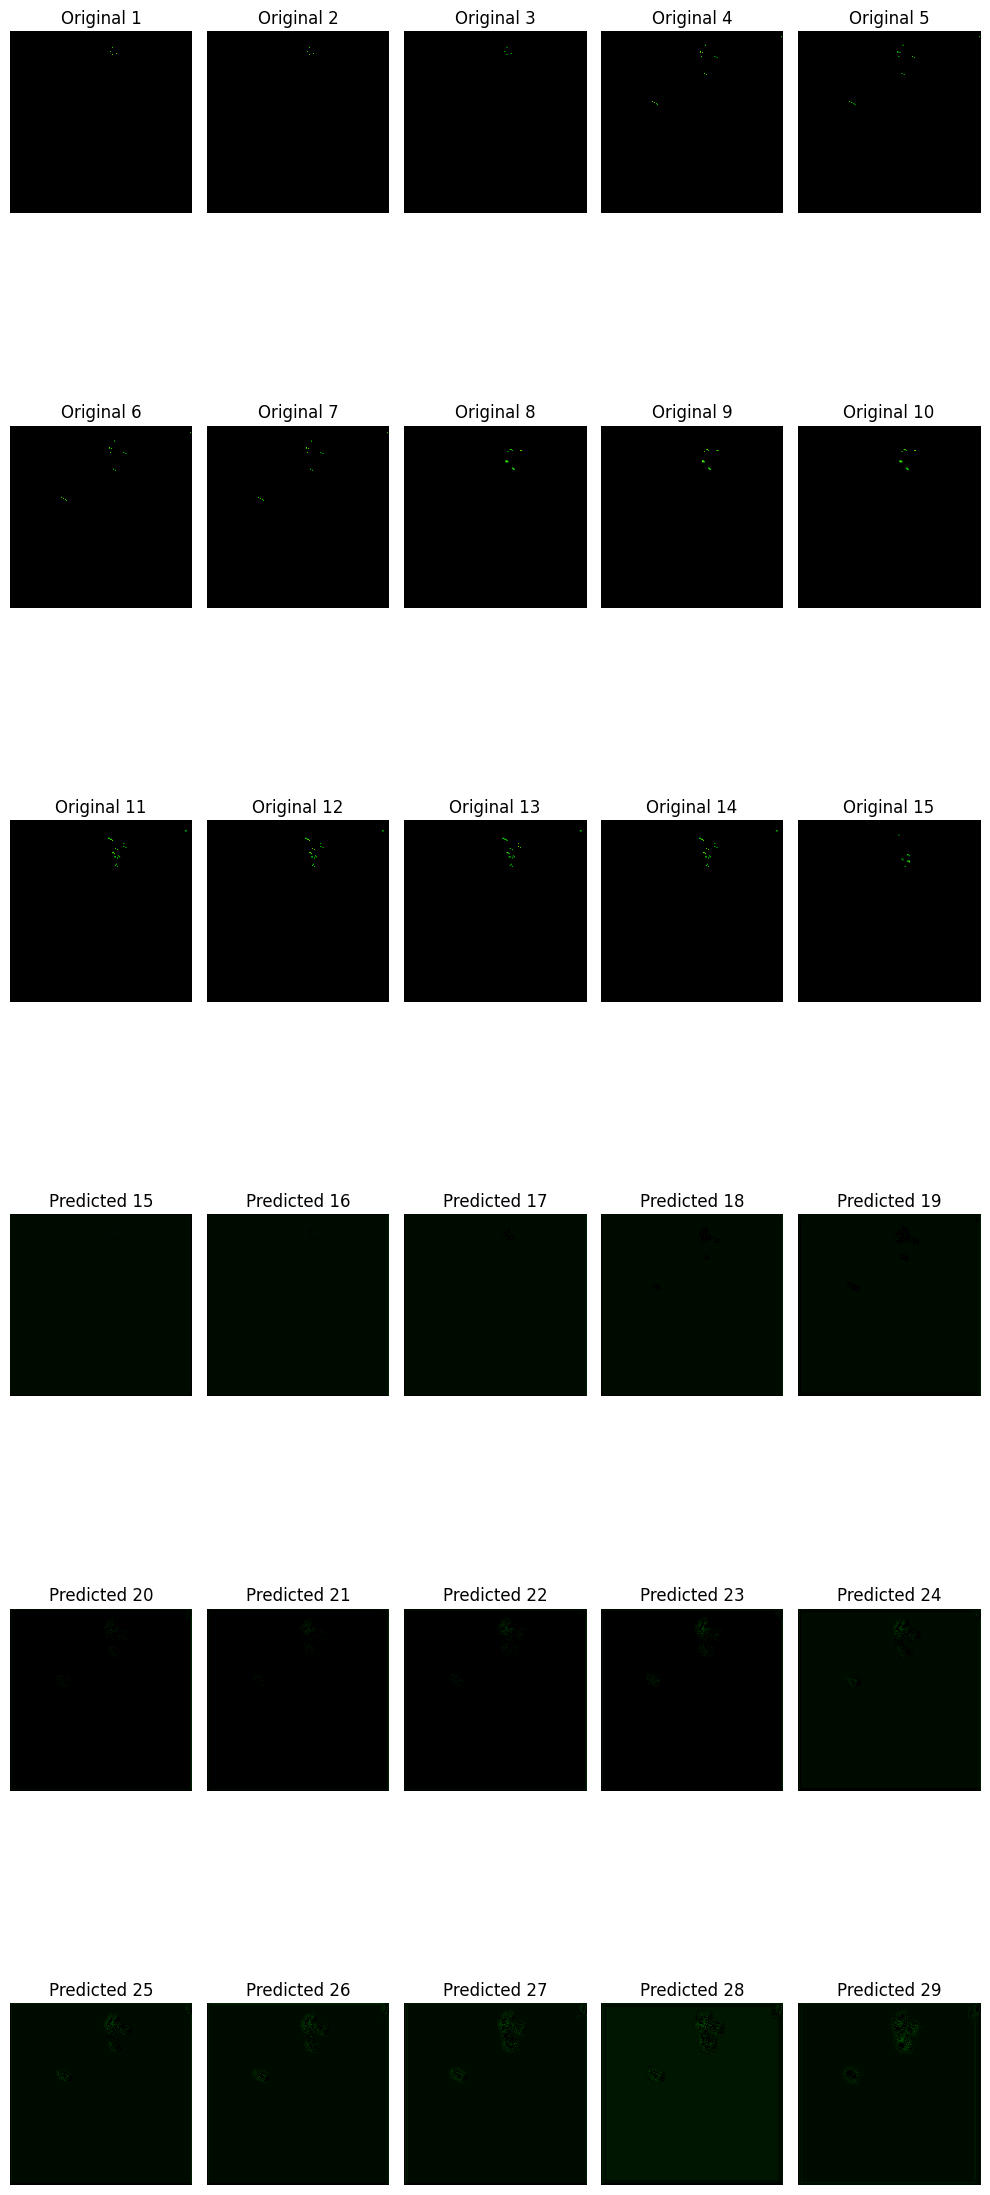

In [14]:
# Sample 15 frames randomly from X_val
frames = X_train[np.random.choice(range(len(X_train)), size=1)[0]]

# Predict a new set of frames
predicted_frames = model.predict(np.expand_dims(frames, axis=0))
predicted_frames = np.squeeze(predicted_frames, axis=0)

# Construct a figure for the original and predicted frames (5 rows of 3 columns each)
fig, axes = plt.subplots(6, 5, figsize=(10, 25))  # 5 rows for original + 5 rows for predicted, 3 columns each

# Plot the original frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    ax.imshow(np.squeeze(frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Original {idx + 1}")
    ax.axis("off")

# Plot the predicted frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row + 3, col]  # Offset by 5 rows to separate original and predicted
    ax.imshow(np.squeeze(predicted_frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Predicted {idx + 15}")
    ax.axis("off")

# Display the figure
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


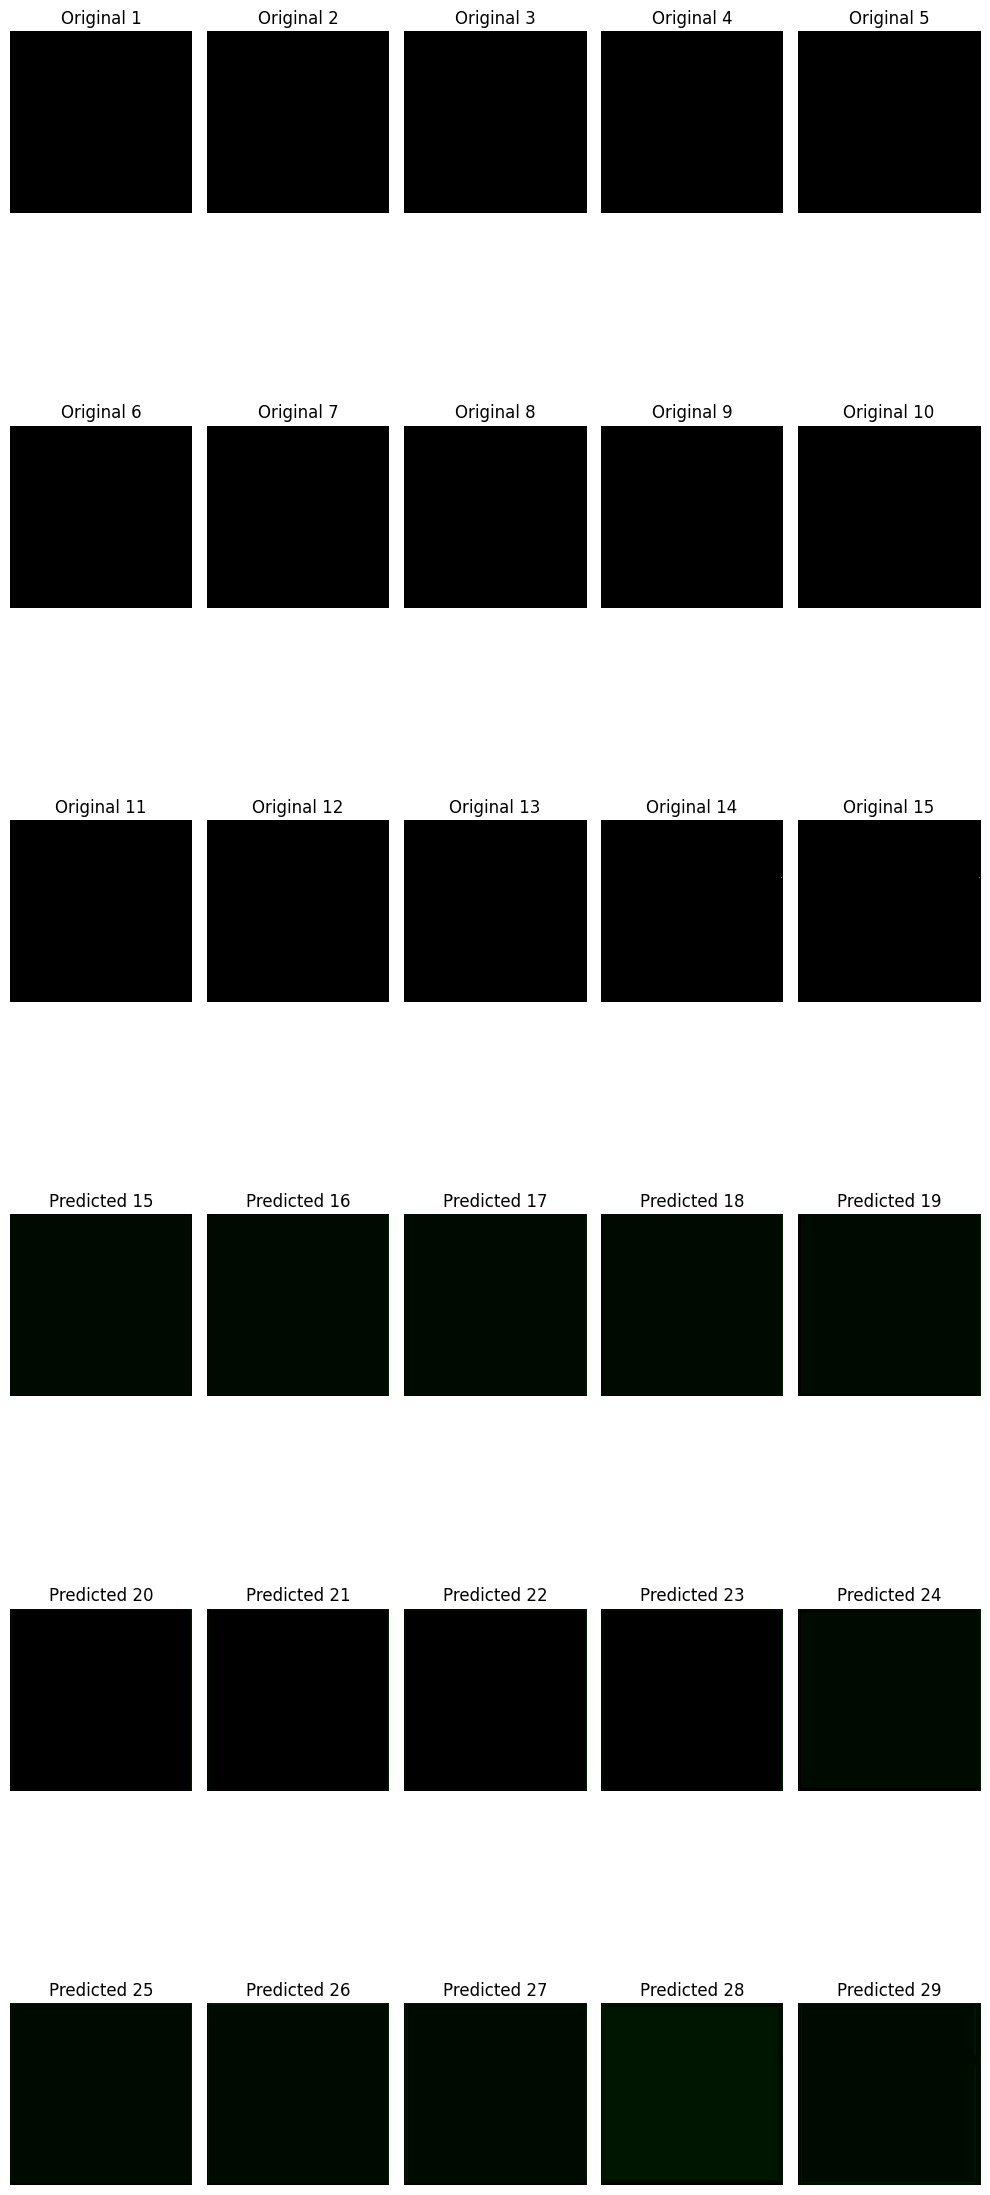

In [15]:
# Sample 15 frames randomly from X_val
frames = X_val[np.random.choice(range(len(X_val)), size=1)[0]]

# Predict a new set of frames
predicted_frames = model.predict(np.expand_dims(frames, axis=0))
predicted_frames = np.squeeze(predicted_frames, axis=0)

# Construct a figure for the original and predicted frames (5 rows of 3 columns each)
fig, axes = plt.subplots(6, 5, figsize=(10, 25))  # 5 rows for original + 5 rows for predicted, 3 columns each

# Plot the original frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    ax.imshow(np.squeeze(frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Original {idx + 1}")
    ax.axis("off")

# Plot the predicted frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row + 3, col]  # Offset by 5 rows to separate original and predicted
    ax.imshow(np.squeeze(predicted_frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Predicted {idx + 15}")
    ax.axis("off")

# Display the figure
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


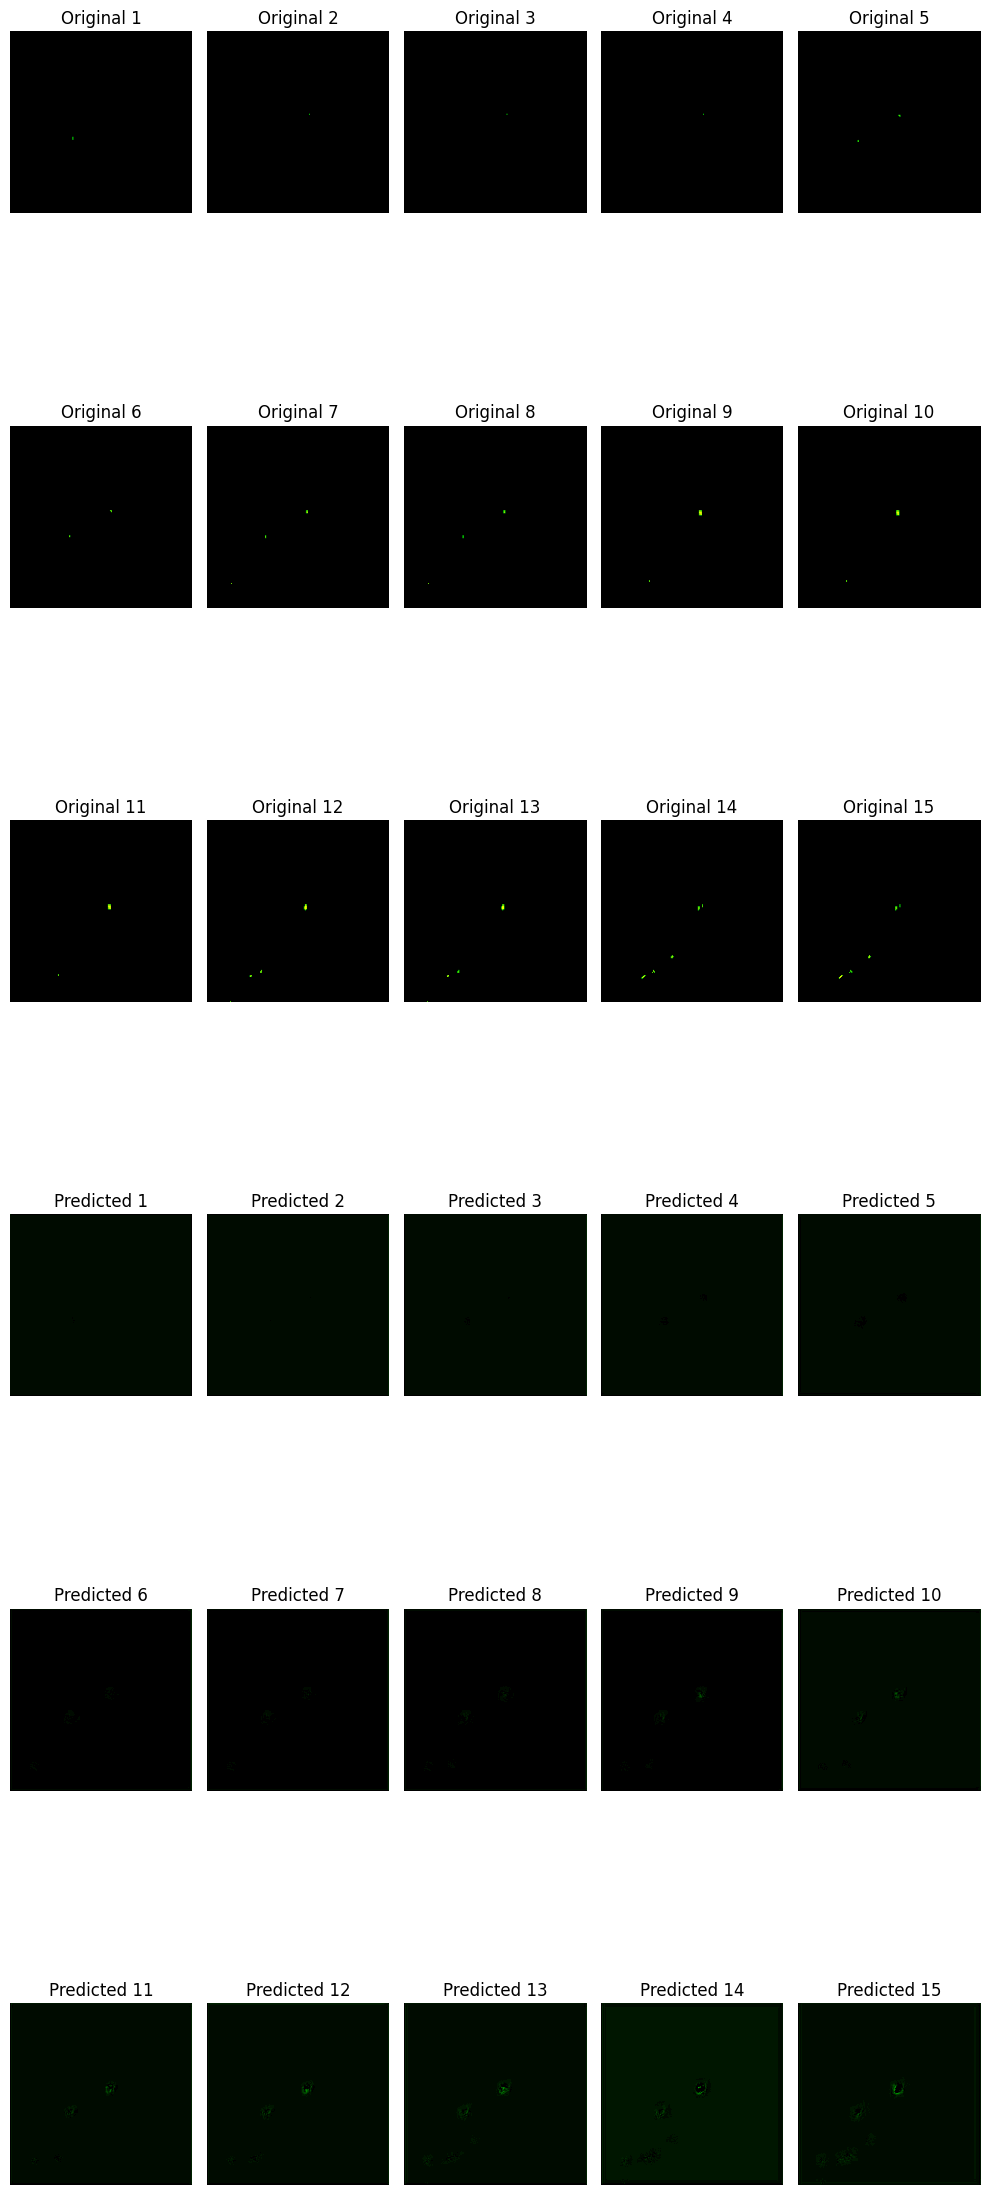

In [16]:
# Sample 15 frames randomly from X_val
frames = X_train[np.random.choice(range(len(X_train)), size=1)[0]]

# Predict a new set of frames
predicted_frames = model.predict(np.expand_dims(frames, axis=0))
predicted_frames = np.squeeze(predicted_frames, axis=0)

# Construct a figure for the original and predicted frames (5 rows of 3 columns each)
fig, axes = plt.subplots(6, 5, figsize=(10, 25))  # 5 rows for original + 5 rows for predicted, 3 columns each

# Plot the original frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row, col]
    ax.imshow(np.squeeze(frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Original {idx + 1}")
    ax.axis("off")

# Plot the predicted frames (5x3)
for idx in range(15):
    row, col = divmod(idx, 5)
    ax = axes[row + 3, col]  # Offset by 5 rows to separate original and predicted
    ax.imshow(np.squeeze(predicted_frames[idx]), cmap=radar_cmap, norm=norm)
    ax.set_title(f"Predicted {idx + 1}")
    ax.axis("off")

# Display the figure
plt.tight_layout()
plt.show()

In [17]:
# Constants for folder paths
FOLDER_A = root_dir + 'data/new_npy_files'
FOLDER_B = root_dir + 'data/npy_files'
FOLDER_C = root_dir + 'data/old_npy_files'

# Helper function to parse the file name into a datetime object
def parse_filename_to_datetime(filename):
    try:
        return datetime.strptime(filename, "%d-%m-%Y-%H%M")
    except ValueError:
        raise ValueError(f"File name {filename} does not follow the expected format")

# Step 1: Find the most recent file in Folder B
def get_last_file_date(folder_b):
    # List only files (not directories)
    files = [f for f in os.listdir(folder_b) if os.path.isfile(os.path.join(folder_b, f))]
    
    # Filter out any non-matching files (if needed)
    files = [f for f in files if f.endswith('.npy')]  # Adjust extension if needed
    if not files:
        raise FileNotFoundError("Folder B is empty or no valid files found")

    # Sort files based on parsed date from the file name
    files.sort(key=lambda f: parse_filename_to_datetime(f[:-4]))  # Adjusting for file extension
    
    # Get the latest file
    last_file = files[-1]
    last_file_date = parse_filename_to_datetime(last_file[:-4])  # Parse date from file name
    return last_file_date

# Step 2: Move all files from Folder B to Folder C
def move_files_from_b_to_c(folder_b, folder_c):
    if not os.path.exists(folder_c):
        os.makedirs(folder_c)
    
    for file_name in os.listdir(folder_b):
        source = os.path.join(folder_b, file_name)
        
        # Ensure it's a file, not a directory
        if os.path.isfile(source):
            destination = os.path.join(folder_c, file_name)
            shutil.move(source, destination)
            print(f"Moved {file_name} from {folder_b} to {folder_c}")

# Step 3: Move 1 hour of files from Folder A to Folder B
def move_files_from_a_to_b(folder_a, folder_b, last_file_date):
    # Calculate the 1-hour window
    start_time = last_file_date
    end_time = start_time + timedelta(hours=1.1)

    # List and sort files in Folder A
    files = [f for f in os.listdir(folder_a) if os.path.isfile(os.path.join(folder_a, f))]
    
    for file_name in sorted(files):
        try:
            # Extract the date from the file name
            file_date = parse_filename_to_datetime(file_name[:-4])  # Removing file extension if needed
            
            # Check if the file falls within the 1-hour window
            if start_time <= file_date < end_time:
                # Check if the file already exists in Folder B
                if os.path.exists(os.path.join(folder_b, file_name)):
                    raise FileExistsError(f"File {file_name} already exists in Folder B. Stopping process.")
                
                # Move file to Folder B
                shutil.move(os.path.join(folder_a, file_name), os.path.join(folder_b, file_name))
                print(f"Moved {file_name} from {folder_a} to {folder_b}")
        
        except ValueError:
            print(f"Skipping file {file_name}: Invalid date format")

# Main script execution
if __name__ == "__main__":
    try:
        # Get the most recent file's date from Folder B
        last_file_date = get_last_file_date(FOLDER_B)
        print(f"Last file date in Folder B: {last_file_date}")

        # Step 2: Move all files from Folder B to Folder C
        move_files_from_b_to_c(FOLDER_B, FOLDER_C)

        # Step 3: Move 1-hour worth of files from Folder A to Folder B
        move_files_from_a_to_b(FOLDER_A, FOLDER_B, last_file_date)

    except Exception as e:
        print(f"Error: {str(e)}")

Last file date in Folder B: 2024-10-09 04:58:00
Moved 09-10-2024-0400.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0402.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0404.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0406.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0408.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0410.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0412.npy from /root/radar-data/radar_data/data/npy_files to /root/radar-data/radar_data/data/old_npy_files
Moved 09-10-2024-0414.npy from /root/radar-data/radar_data/data/npy_files to /root/r